# PREDICTING CREDIT CARDS APPROVALS

In [1]:
import pandas as pd
import numpy as np
cc=pd.read_csv('D:/DS projects/crx.data',header=None)
cc.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


In [2]:
cc.shape


(690, 16)

In [3]:
import seaborn as sns
sns.set(style="ticks")
sns.pairplot(cc,hue=15)

# Preprocessing

## Missing values

In [4]:
# Replace the '?'s with NaN
cc=cc.replace('?',np.NaN)
cc.isnull().sum()

0     12
1     12
2      0
3      6
4      6
5      9
6      9
7      0
8      0
9      0
10     0
11     0
12     0
13    13
14     0
15     0
dtype: int64

In [5]:
cat_features=[]
num_features=[]
for col in cc:
    if cc[col].dtype == 'object':
        cat_features.append(col)
    else:
        num_features.append(col)
     
print(cat_features)
print(num_features)

from sklearn.impute import SimpleImputer

imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
cc[cat_features]= imp_mode.fit_transform(cc[cat_features])

imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
cc[num_features] = imp_mode.fit_transform(cc[num_features])

cc.tail()

[0, 1, 3, 4, 5, 6, 8, 9, 11, 12, 13, 15]
[2, 7, 10, 14]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
685,b,21.08,10.085,y,p,e,h,1.25,f,f,0.0,f,g,00260,0.0,-
686,a,22.67,0.750,u,g,c,v,2.00,f,t,2.0,t,g,00200,394.0,-
687,a,25.25,13.500,y,p,ff,ff,2.00,f,t,1.0,t,g,00200,1.0,-
688,b,17.92,0.205,u,g,aa,v,0.04,f,f,0.0,f,g,00280,750.0,-
689,b,35.00,3.375,u,g,c,h,8.29,f,f,0.0,t,g,00000,0.0,-


### Ordinal Encoder

In [6]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
cc[cat_features] = enc.fit_transform(cc[cat_features])
cc.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1.0,156.0,0.000,1.0,0.0,12.0,7.0,1.25,1.0,1.0,1.0,0.0,0.0,68.0,0.0,0.0
1,0.0,328.0,4.460,1.0,0.0,10.0,3.0,3.04,1.0,1.0,6.0,0.0,0.0,11.0,560.0,0.0
2,0.0,89.0,0.500,1.0,0.0,10.0,3.0,1.50,1.0,0.0,0.0,0.0,0.0,96.0,824.0,0.0
3,1.0,125.0,1.540,1.0,0.0,12.0,7.0,3.75,1.0,1.0,5.0,1.0,0.0,31.0,3.0,0.0
4,1.0,43.0,5.625,1.0,0.0,12.0,7.0,1.71,1.0,0.0,0.0,0.0,2.0,37.0,0.0,0.0


### Train Test Split

In [7]:
#Split dataset into train and test sets
from sklearn.model_selection import train_test_split
X = cc.drop([15],axis=1)
y = cc[15]
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.20, random_state=42)

### Feature Scaling

In [8]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
rescaledX_train = scaler.fit_transform(X_train)
rescaledX_test = scaler.fit_transform(X_test)

### Model Selection

### Hyperparameter Tuning

In [9]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.model_selection import GridSearchCV

#param_grid = {'n_neighbors': np.arange(1, 100)}
param_range = np.arange(1, 20)
param_range_fl=np.logspace(-10, 10)

param_grid_logreg = {'C':param_range_fl}
param_grid_knn = {'n_neighbors':param_range}
param_grid_svm = {'C':param_range}
algos = [LogisticRegression(),KNeighborsClassifier(),svm.SVC()]

grids = [param_grid_logreg,param_grid_knn,param_grid_svm]

models = dict(zip(algos,grids))
def run_tuning(algo,param_grid):
    print("ESTIMATOR: {}".format(str(algo)))
    algo_cv=GridSearchCV(algo,param_grid,cv=5)
    algo_cv.fit(rescaledX_train,y_train)
    print ("BEST TRAINING ACCURACY: {0} with Tuned Parameters: {1}".format(algo_cv.best_score_,algo_cv.best_params_))
    y_pred = algo_cv.predict(rescaledX_test)
    print("BEST TEST ACCURACY: {}".format(accuracy_score(y_test,y_pred)))
    print("---------------------------------------------------\n")
    
    return algo_cv

best_clfs=[]
for i in range(len(algos)):
    best_clfs.append(run_tuning(algos[i],grids[i]))
  

ESTIMATOR: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
BEST TRAINING ACCURACY: 0.8695652173913043 with Tuned Parameters: {'C': 0.014563484775012445}
BEST TEST ACCURACY: 0.8405797101449275
---------------------------------------------------

ESTIMATOR: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
BEST TRAINING ACCURACY: 0.8605072463768116 with Tuned Parameters: {'n_neighbors': 6}
BEST TEST ACCURACY: 0.8768115942028986
---------------------------------------------------

ESTIMATOR: SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', 

### Scoring Metrics

Metrics for Logistic Regression model.
          recall: 0.8529411764705882
          precision: 0.8285714285714286
          f1: 0.8405797101449276
          auc: 0.8407563025210083


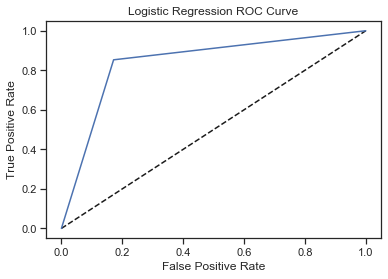

|------------------------------------------------------------------|
Metrics for K-Nearest Neighbors model.
          recall: 0.9411764705882353
          precision: 0.8311688311688312
          f1: 0.8827586206896552
          auc: 0.8777310924369748


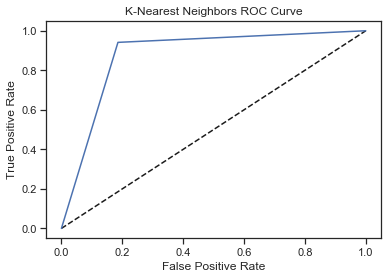

|------------------------------------------------------------------|
Metrics for SVM model.
          recall: 0.8529411764705882
          precision: 0.8529411764705882
          f1: 0.8529411764705882
          auc: 0.8550420168067228


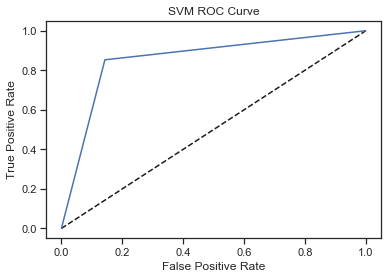

|------------------------------------------------------------------|


In [21]:
import matplotlib.pyplot as plt
grid_dict = {0: 'Logistic Regression', 1: 'K-Nearest Neighbors', 2: 'SVM'}
metrics_list = {'recall': recall_score, 
           'precision': precision_score, 
           'f1': f1_score}
for idx, clf in enumerate(best_clfs):
        y_pred = clf.predict(rescaledX_test)
        print('Metrics for ' + grid_dict[idx] + ' model.')
        for metric in metrics_list:
            print(' ' * 10 + metric + ': ' + '{}'.format(metrics_list[metric](y_test, y_pred)))
        from sklearn import metrics
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
        print(' ' * 10 + "auc: {}".format(metrics.auc(fpr, tpr)))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr, tpr, label=grid_dict[idx])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('{} ROC Curve'.format(grid_dict[idx]))
        plt.show();
        print('|------------------------------------------------------------------|')


# Classifier Chosen: K-Nearest Neighbors